<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. Sort the alarms into 'Errors' and 'Valid'. i.e. Alarm Duration < PAAP & Cycle Time is a Valid Scenario. Errors are EITHER Alarm Duration > PAAP OR Alarm Duration > PAAP & Cycle Time
    Have decided to take the subset of Duration < Cycle Time as GT's that make feasible sense.
10. Carry out More detailed analysis to gauge size of the prize. Here we have taken the 95th percentile of cycle times to remove outlier GT's. We had already previously removed Trial Recipes. Then:
    •	Analyse if they have taken each alarm once or twice. Need to sort by Null i.e. (Mahesh is handling)
    •	Count of 'Valid' Alarms. Calculate percentage out of all GT's Produced 
    •	Recalculate time saving per cycle time for start_time and ProducedOn Time. i.e. Redo Allocation of GT's
    •	See Date dependence of PA alarms. (one day may be particularly bad due to converyor belt issue, or Recipe   inherent etc.) (Automation Conveyor may have an issue on one particylar day). See if Date Dependent
11. Continuation of 10, to carry out more detailed analysis to gauge size of the prize
    •	See correlation coeff with Duration and Cycle time/PAAP time
    •	General Analysis of PAAP Times
    •	Check next and previous tyres for the Errors.   
    •	Investigate for other TBM's
12.	Plot these comparisons and highlight your observations. Add any other analysis as we go along: 
    •	Total CT variation - m/c wise
    •	CT variation - application wise
    •	Total CT variation - Diameter wise
    •	Total CT variation - Recipe wise
    •	Number of changeovers - m/c wise 
    •	Number of changeovers - due to recipe, due to diameter
13. PREASSEMBLY LENGTH NOT CORRECT Alarm investigation. Alarm Duration Distribution, as this alarms Duration IS linked to Machine Stoppage Time. GT allocation, and Alarm duration vs PAAP time check. All seems okay, as vast majority are Scenario 1.
    • Scenario 1 : Alarm Duration < PAAP Times
    • Scenario 2 : Alarm Duration > PAAP Times 
    • Scenario 3 : Alarm Duration > PAAP Times & Cycle Time
14. Plot Probablity Density of 3 Scenarios, KDE Distribution of Cycle Times (not filtered by SKU), and cycle time percentiles. Compare GT's before and after Outlier removal at 85th percentile, and investigate effect on PAAP time. Conculsion was:
    Projected reduction in average Cycle Time If Alarm was non-existent: 0.683s
    Projected reduction in average PAAP Time If Alarm was non-existent: 0.499s


In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
TBM = TBM()
p = bcolors()
FS = Feature_Selection()
DF = Data_Functions()

In [2]:
df_PA_tbm_join_Alarm = pd.read_pickle('./pkl/PA_Alarms_joined_with_tbm_data_alarm_2.pkl')
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")

1. Scenario 1 : Alarm Duration < PAAP Times
2. Scenario 2 : Alarm Duration > PAAP Times 
3. Scenario 3 : Alarm Duration > PAAP Times & Cycle Time

In [8]:
p.printg(f'no. Total Alarms: {p.ENDC} {len(df_PA_tbm_join_Alarm)}')
scen1 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] < df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 1 Alarms: {p.ENDC} {len(scen1)}')
scen2 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 2 Alarms: {p.ENDC} {len(scen2)}')
scen3 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP) & (df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.cycle_time_s)]
p.printg(f'no. Scenario 3 Alarms: {p.ENDC} {len(scen3)}')
print('\n')
p.printg(f'Scenario 1 PAAP mean: {p.ENDC} {scen1.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 2 PAAP mean: {p.ENDC} {scen2.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 3 PAAP mean: {p.ENDC} {scen3.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')

no. Total Alarms:  2354
no. Scenario 1 Alarms:  2333
no. Scenario 2 Alarms:  21
no. Scenario 3 Alarms:  1


Scenario 1 PAAP mean:  37.73134631268517
Scenario 2 PAAP mean:  9.02423822312128
Scenario 3 PAAP mean:  3.927999973297119


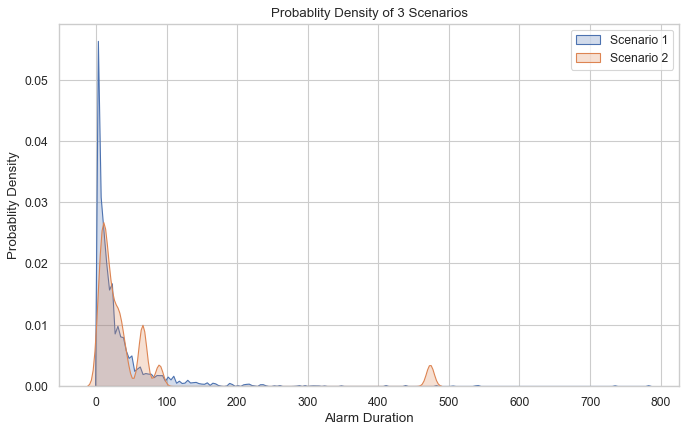

In [5]:
DF.KDE_dist_plotter_multiple(list_of_series = [scen1.Duration, scen2.Duration], label=['Scenario 1', 'Scenario 2'], smoothness = .1, xlabel='Alarm Duration', title = 'Probablity Density of 3 Scenarios')

In [10]:
subset = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] < df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
# Note that We have lost due to discarded trial recipes(215) & Error type II (190), and Cases where alarm occurs >1 for the same GT(110) 
p.printc(f'Percentage Alarm\'s Retained: {p.ENDC} {round(len(subset)/2441*100, 2)}%')

Percentage Alarm's Retained:  95.58%


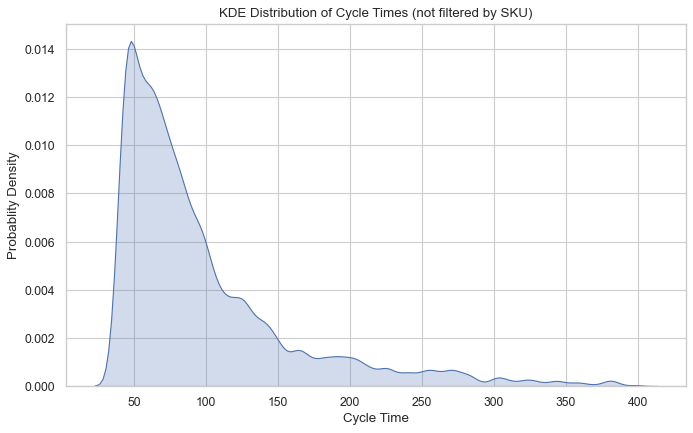

In [11]:
DF.KDE_dist_plotter(series=df_PA_tbm_join_Alarm[df_PA_tbm_join_Alarm.cycle_time_s < 400].cycle_time_s, title='KDE Distribution of Cycle Times (not filtered by SKU)', ylabel='Probablity Density', xlabel='Cycle Time')

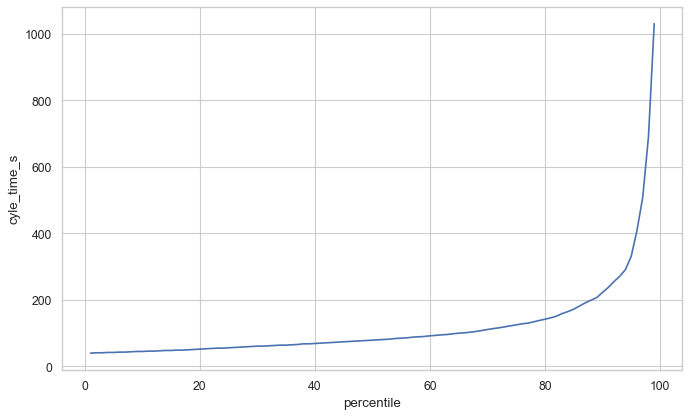

In [12]:
DF.percentile_plotter(df=df_PA_tbm_join_Alarm, column='cycle_time_s')

In [13]:
# Check Percentile Percentile
np.percentile(df_PA_tbm_join_Alarm.cycle_time_s.to_list(), 84)

165.0

In [14]:
df_PA_tbm_join_Alarm.columns

Index(['start_time', 'ProducedOn', 'Duration', 'TimeStamp',
       'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'cycle_time_s', 'RecipeName', 'Id',
       'key', 'Type', 'Name', 'EquipmentID_x'],
      dtype='object')

In [10]:
ridge_data = df_PA_tbm_join_Alarm[['cycle_time_s', 'RecipeName']]
ridge_data_filter = ridge_data[ridge_data['cycle_time_s'] < 300]
count = ridge_data_filter.groupby('RecipeName').size()
ridge_data_filter = pd.merge(count.to_frame(), ridge_data_filter,on='RecipeName')
ridge_data_filter['count'] = ridge_data_filter[0].apply(str)
ridge_data_filter['RecipeName'] = ridge_data_filter['RecipeName'] + ' (' + ridge_data_filter['count'] + ')'
ridge_data_filter.drop([0, 'count'], axis=1, inplace=True)

c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\

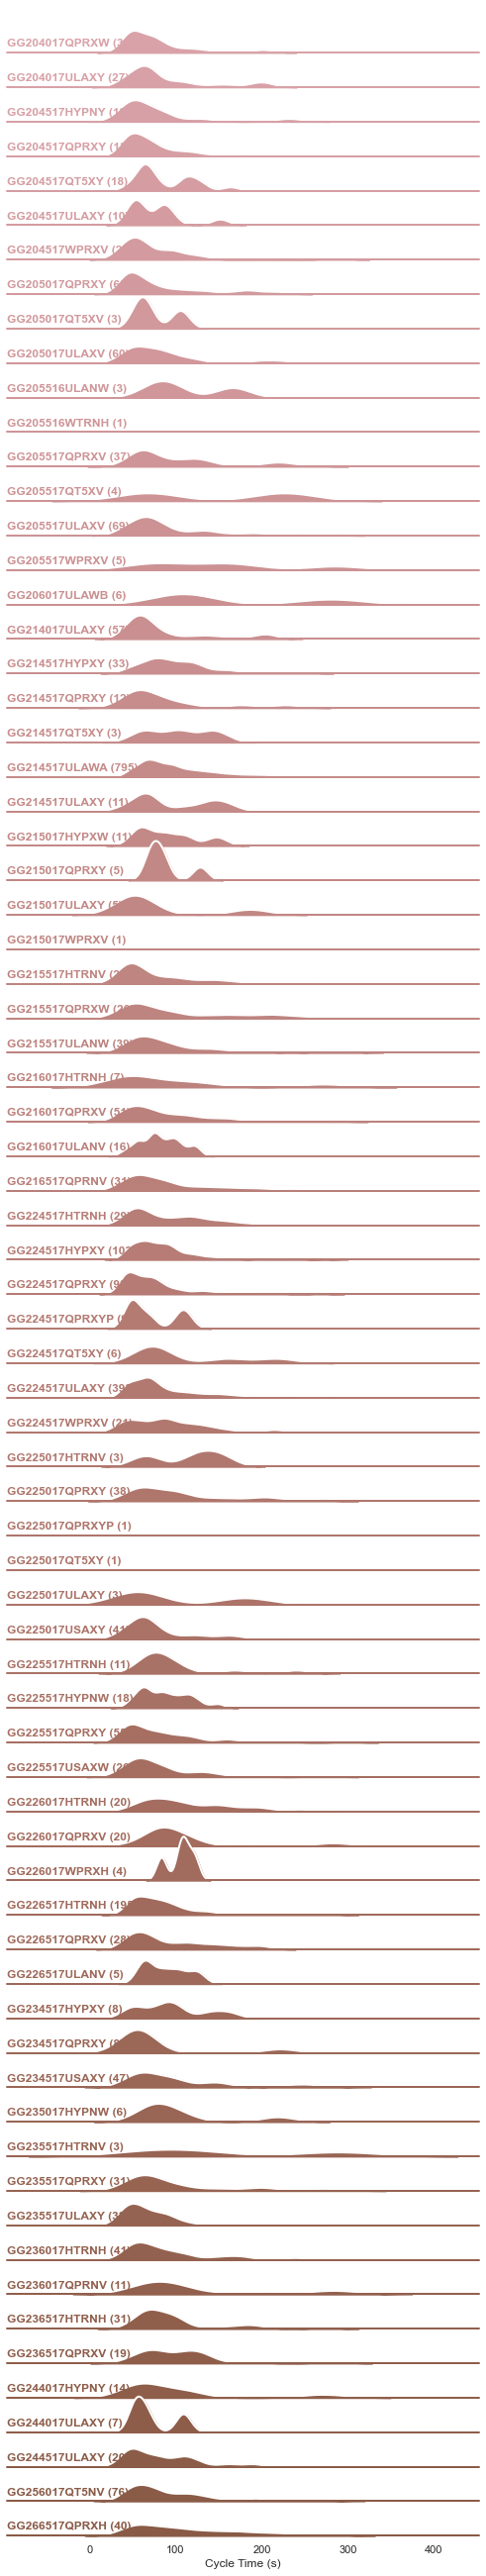

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(ridge_data_filter.RecipeName.unique()), start=1.4, rot=-.25, light=.7, dark=.4)
g = sns.FacetGrid(ridge_data_filter, row="RecipeName", hue="RecipeName", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "cycle_time_s",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "cycle_time_s", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "cycle_time_s")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xlabel="Cycle Time (s)", ylabel="")
g.despine(bottom=True, left=True)
plt.show()

In [15]:
# Check Percentile Percentile of All TBM Data
percent = 95
p.gv(f'The {percent}\'th percentile (Cycle Time s) Overall:', np.percentile(df_tbm.cycle_time_s.to_list(), percent))

The 95'th percentile (Cycle Time s) Overall: 195.0


In [16]:
tbm_with_alarm = df_tbm[df_tbm.Id.isin(subset.Id.to_list())][['RecipeName', 'cycle_time_s', 'Id', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'ProducedOn' ]]
tbm_without_alarm = df_tbm[~df_tbm.Id.isin(subset.Id.to_list())][['RecipeName', 'cycle_time_s', 'Id', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'ProducedOn' ]]
# Check Percentile Percentile Of two Sub Groups
percent = 85
p.printg(f'The {percent}\'th percentile (Cycle Time s) Alarm: {p.ENDC}{np.percentile(tbm_with_alarm.cycle_time_s.to_list(), percent)}')
p.printg(f'The {percent}\'th percentile (Cycle Time s) No Alarm: {p.ENDC}{np.percentile(tbm_without_alarm.cycle_time_s.to_list(), percent)}')

The 85'th percentile (Cycle Time s) Alarm: 169.0
The 85'th percentile (Cycle Time s) No Alarm: 90.0


What is a realistic Alarm duration. is 12 miutes realistic? NO Alarm should be 25 seconds most of the time. That is the mode. 

Text(0.5, 1.0, "Cycle Time Percentile's for Alarm GTs")

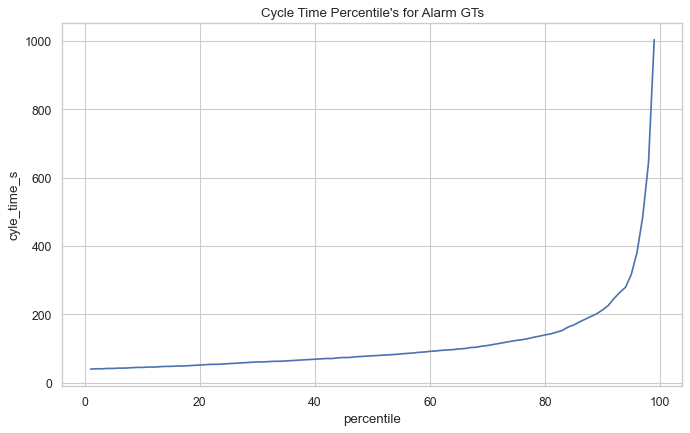

In [19]:
DF.percentile_plotter(df=tbm_with_alarm, column='cycle_time_s')
plt.title('Cycle Time Percentile\'s for Alarm GTs')

Text(0.5, 1.0, "Cycle Time Percentile's for Non Alarm GTs")

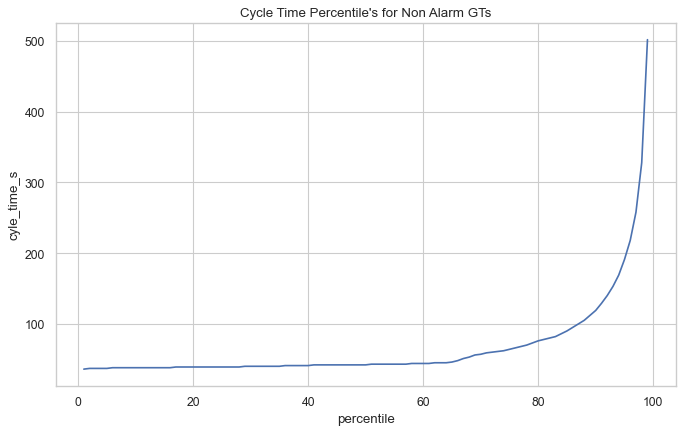

In [20]:
DF.percentile_plotter(df=tbm_without_alarm, column='cycle_time_s')
plt.title('Cycle Time Percentile\'s for Non Alarm GTs')

In [21]:
tbm_with_alarm = df_tbm[df_tbm.Id.isin(subset.Id.to_list())][['RecipeName', 'cycle_time_s', 'Id', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'ProducedOn' ]]
tbm_without_alarm = df_tbm[~df_tbm.Id.isin(subset.Id.to_list())][['RecipeName', 'cycle_time_s', 'Id', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'ProducedOn' ]]

p.printg(f'Alarm GT\'s before Outlier removal at {percent}th percentile: {p.ENDC} {len(tbm_with_alarm)}')
p.printg(f'Non-Alarm GT\'s before Outlier removal at {percent}th percentile: {p.ENDC} {len(tbm_without_alarm)}')
print('\n')

# Remove Outliers i.e. at {percent}th Percentile
tbm_with_alarm = tbm_with_alarm[tbm_with_alarm.cycle_time_s < np.percentile(tbm_with_alarm.cycle_time_s.to_list(), percent)]
tbm_without_alarm = tbm_without_alarm[tbm_without_alarm.cycle_time_s < np.percentile(tbm_without_alarm.cycle_time_s.to_list(), percent)]

p.printg(f'Alarm GT\'s after Outlier removal at {percent}th percentile: {p.ENDC} {len(tbm_with_alarm)}')
p.printg(f'Non-Alarm GT\'s after Outlier removal at {percent}th percentile: {p.ENDC} {len(tbm_without_alarm)}')
print('\n')

p.printg(f'Mean Cycle time (s) where alarm occured: {p.ENDC} {tbm_with_alarm.cycle_time_s.mean()}')
p.printg(f'Mean Cycle time (s) where these alarms didn\'t occur: {p.ENDC} {tbm_without_alarm.cycle_time_s.mean()}')
p.printg(f'Mean Cycle time (s) Difference: {p.ENDC} {tbm_with_alarm.cycle_time_s.mean() - tbm_without_alarm.cycle_time_s.mean()}')
print('\n')

# See differnce in PAAP Cycle Times 
p.printg(f'PAAP cycle time (s) where alarm occured: {p.ENDC} {tbm_with_alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'PAAP cycle time (s) where these alarms didn\'t occur: {p.ENDC} {tbm_without_alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'PAAP cycle time (s) Difference: {p.ENDC} {tbm_with_alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean() - tbm_without_alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')


Alarm GT's before Outlier removal at 85th percentile:  2333
Non-Alarm GT's before Outlier removal at 85th percentile:  108251


Alarm GT's after Outlier removal at 85th percentile:  1981
Non-Alarm GT's after Outlier removal at 85th percentile:  91816


Mean Cycle time (s) where alarm occured:  78.65522463402323
Mean Cycle time (s) where these alarms didn't occur:  46.31335497081119
Mean Cycle time (s) Difference:  32.34186966321204


PAAP cycle time (s) where alarm occured:  27.815836435372873
PAAP cycle time (s) where these alarms didn't occur:  4.186952067658058
PAAP cycle time (s) Difference:  23.628884367714814


In [22]:
from scipy import stats
import numpy as np
p.printg(f'Kolmogrov test on two datasets: {p.ENDC}')
print(stats.ks_2samp(list(tbm_with_alarm.cycle_time_s), list(tbm_without_alarm.cycle_time_s)))

# One-Sample T-Test
# We use a one sample T-test to determine whether our sample mean (observed average) is statistically significantly different to the population mean (expected average).
alarm_list_cycle_times = list(tbm_with_alarm.cycle_time_s)
not_alarm_list_cycle_times = list(tbm_without_alarm.cycle_time_s)
p.printg(f'One-Sample T-Test test on two datasets: {p.ENDC}')
print(stats.ttest_ind(alarm_list_cycle_times, not_alarm_list_cycle_times))


Kolmogrov test on two datasets: 
KstestResult(statistic=0.6270353515669929, pvalue=0.0)
One-Sample T-Test test on two datasets: 
Ttest_indResult(statistic=110.54801711654227, pvalue=0.0)


Our t-statistic value is 192.9, and along with our degrees of freedom this can be used to calculate a p-value. The p-value in this case is outputting as 0, which is far less than the standard thresholds of 0.05 or 0.01, so we reject the null hypothesis and we can say there is a statistically significant difference between the tyres exhiniting this alarm and those that dont.

In [23]:
p.printg(f'These alarms occur in {p.UNDERLINE}{round(len(tbm_with_alarm)/len(df_tbm)*100, 2)}%{p.ENDC} {p.GREEN}of Tyres')

These alarms occur in 1.79% of Tyres


Clearly, this alarm does lead to higher cycle times, but only occurs 2.45% of the time. So is this worth fixing?

Lets pretend the Alarmed GT's had an average Cycle time of the opposite group i.e 54.69 and had an average PAAP time of 4.51

In [24]:
uncorrected = pd.concat([tbm_with_alarm, tbm_without_alarm])
correct_alarm = tbm_with_alarm.assign(cycle_time_s=46.31)
correct_alarm = correct_alarm.assign(VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP=4.18)
corrected = pd.concat([correct_alarm, tbm_without_alarm])

In [25]:
p.printg(f'Projected reduction in average Cycle Time If Alarm was non-existent: {p.ENDC}{round(uncorrected.cycle_time_s.mean() - corrected.cycle_time_s.mean(), 3)}s')
p.printg(f'Projected reduction in average PAAP Time If Alarm was non-existent: {p.ENDC}{round(uncorrected.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean() - corrected.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean(), 3)}s')

Projected reduction in average Cycle Time If Alarm was non-existent: 0.683s
Projected reduction in average PAAP Time If Alarm was non-existent: 0.499s


In [74]:
assert len(uncorrected) == len(corrected)

In [75]:
corrected['corrected'] = 'Corrected'
corrected['Date'] = pd.to_datetime(corrected['ProducedOn']).dt.date

In [76]:
uncorrected['corrected'] = 'Original'
uncorrected['Date'] = pd.to_datetime(uncorrected['ProducedOn']).dt.date

In [77]:
plot_concat = pd.concat([uncorrected, corrected])

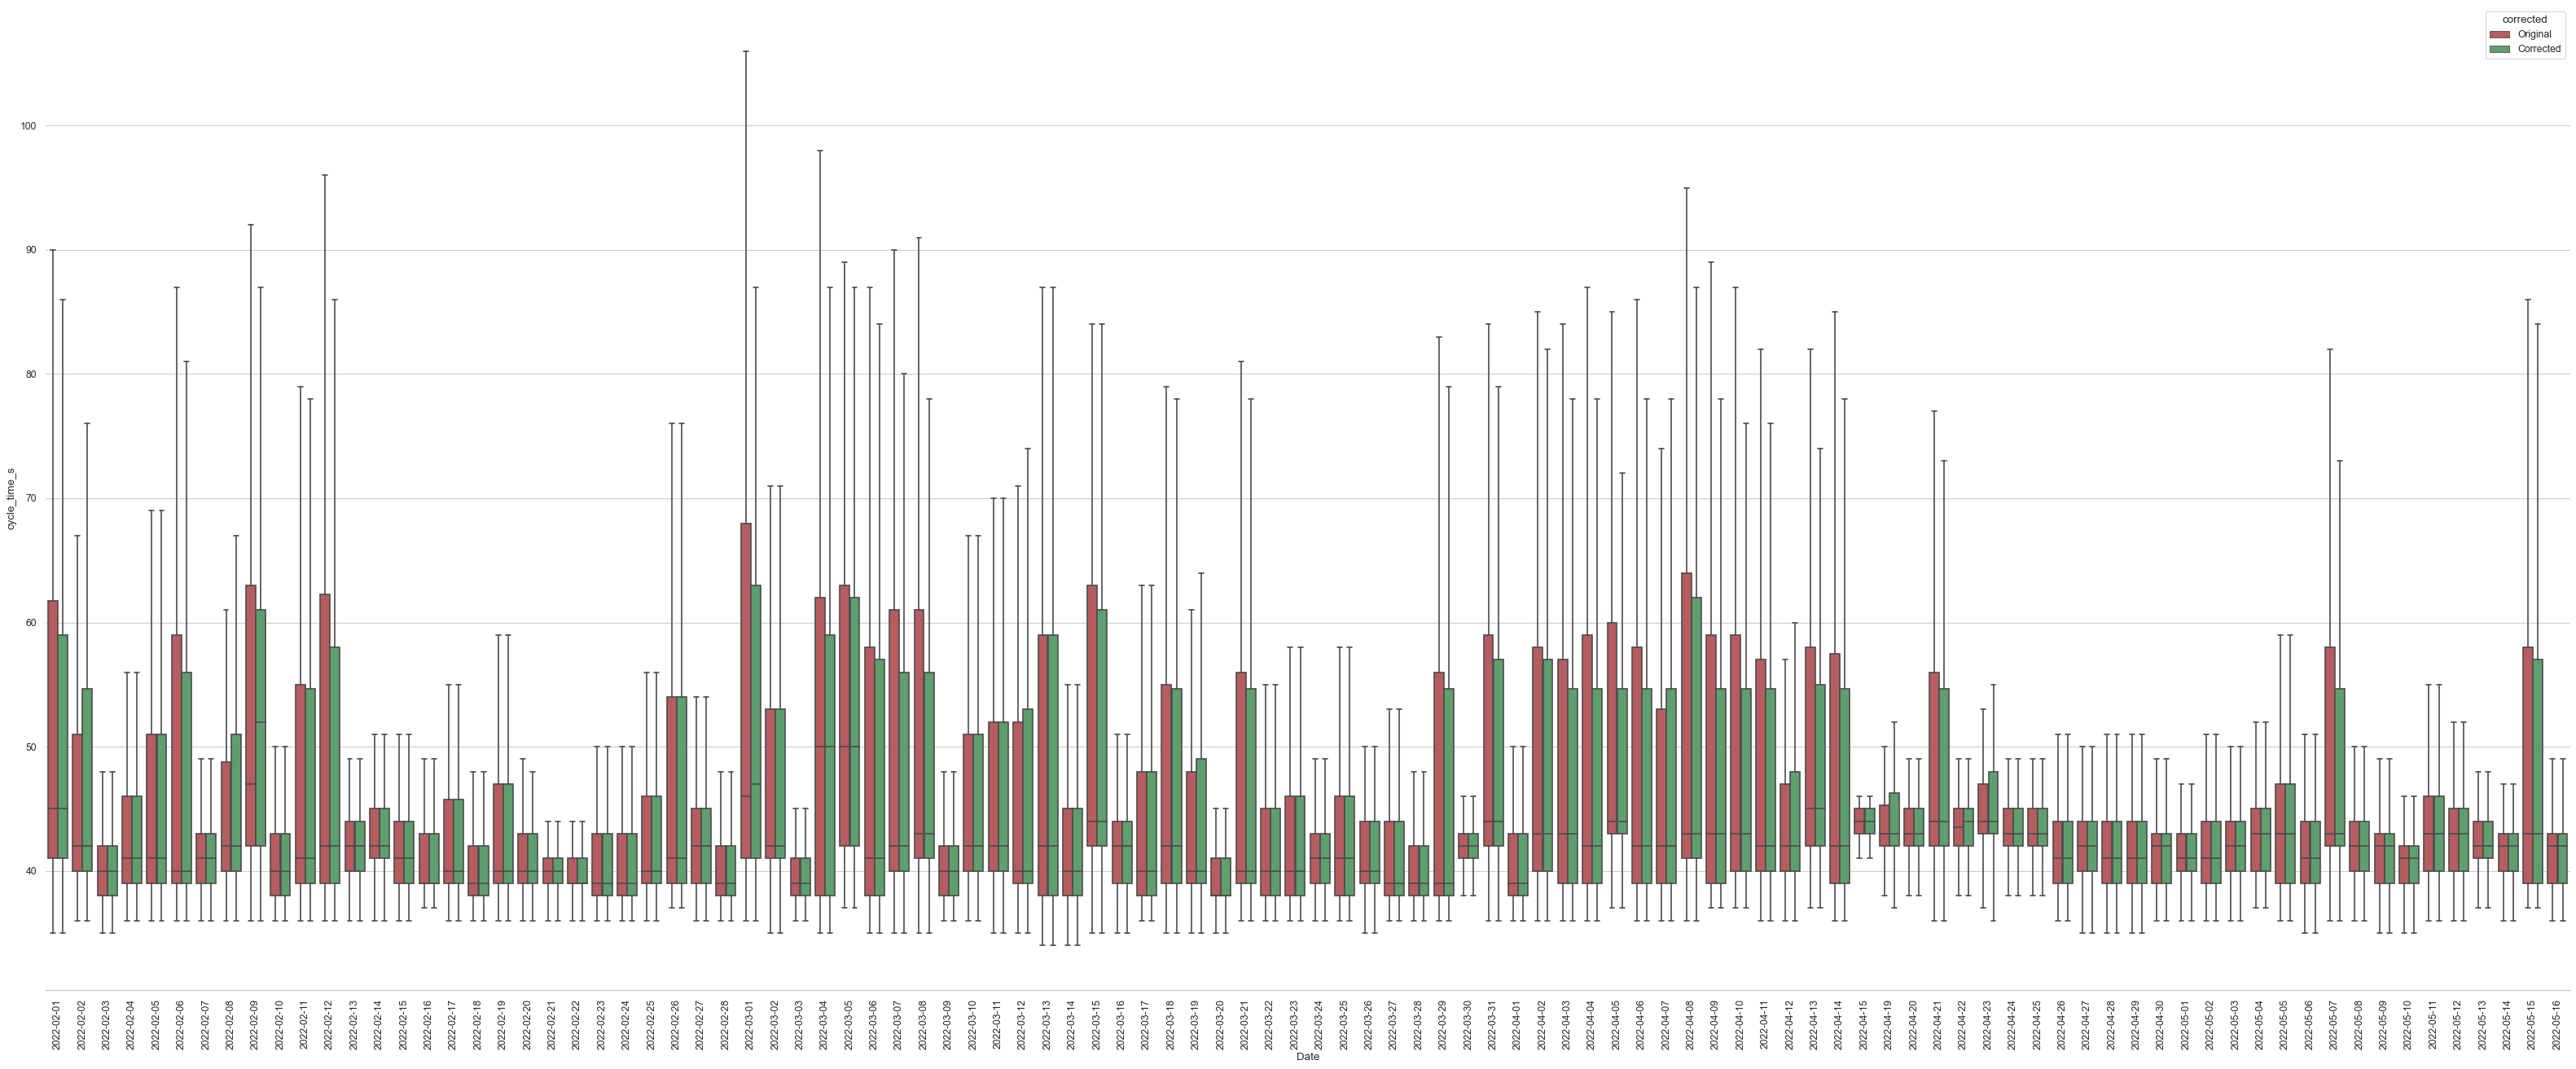

In [86]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(50, 20), dpi=80)
# Draw a nested boxplot to show Corrected and uncorrected times by Date
sns.boxplot(x="Date", y="cycle_time_s",
            hue="corrected", palette=["r", "g"],
            data=plot_concat, showfliers = False)

plt.xticks(rotation = 90)
sns.despine(left=True)

Seaborn uses whis=1.5 as the default for outlier calculation as a function of IQR. Defined as the Proportion of the IQR past the low and high quartiles to extend the plot whiskers. 

For a normal distribution, the interquartile range contains 50% of the population and 1.5 * IQR contains about 99%.

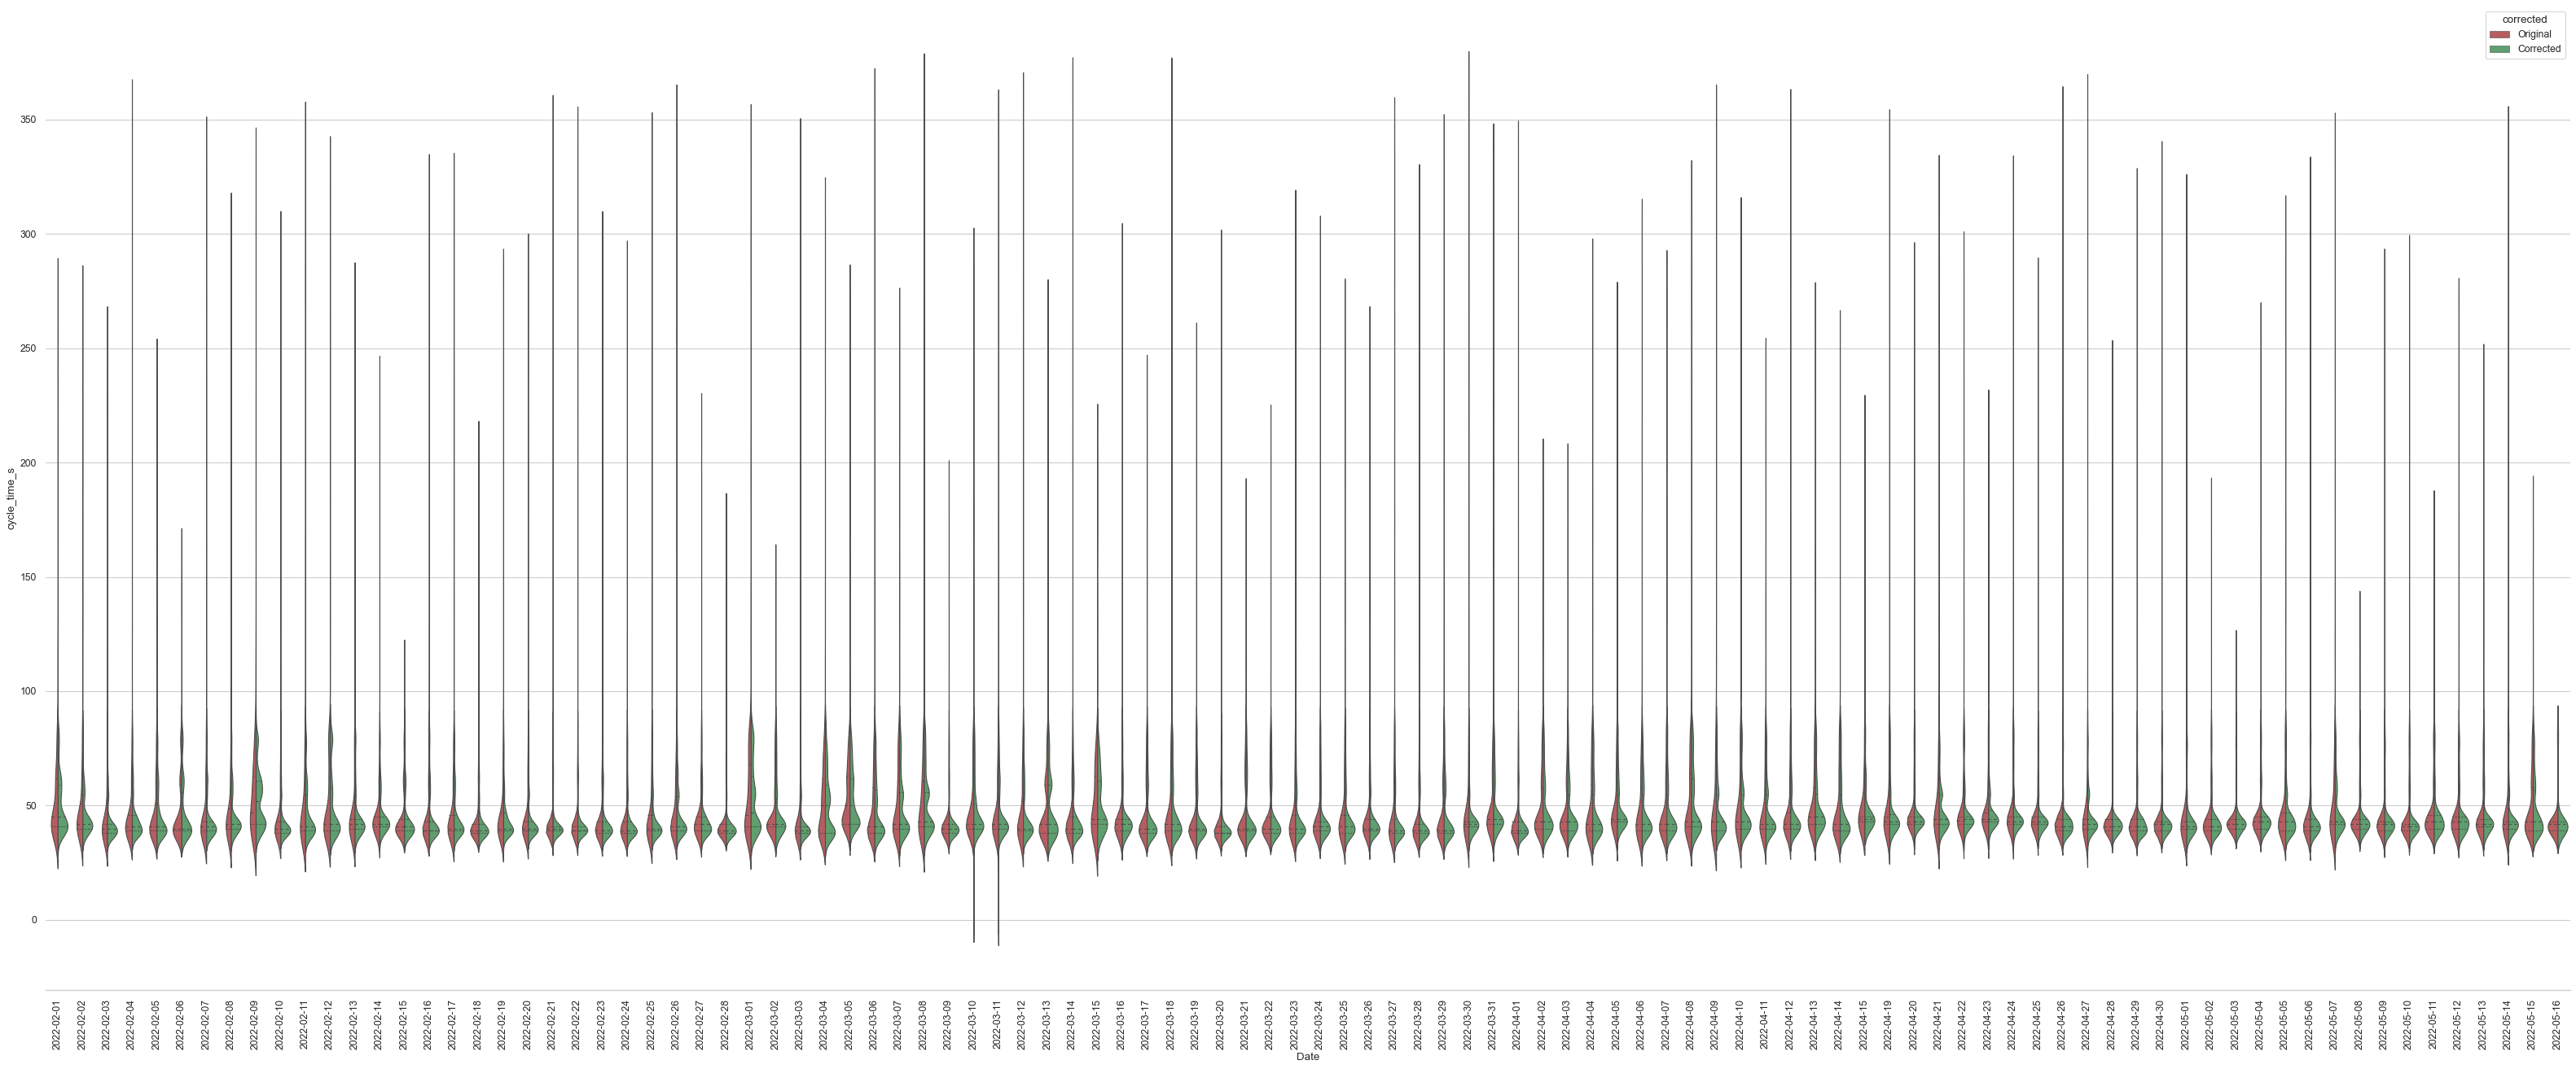

In [84]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(50, 20), dpi=80)
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=plot_concat, x="Date", y="cycle_time_s", hue="corrected",
               split=True, inner="quart", linewidth=1,
               palette=["r", "g"])
               

plt.xticks(rotation = 90)
sns.despine(left=True)

In [26]:
p.printg(f'Percentage of time Alarm Duration accounts for overall Total Cycle Time (%): {p.ENDC}{round((subset[subset.cycle_time_s < 195].Duration.sum() / df_tbm.cycle_time_s.sum())* 100, 3)}%')

Percentage of time Alarm Duration accounts for overall Total Cycle Time (%): 0.601%


In [88]:
subset.to_pickle('./pkl/valid_alarm_GTs')